<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/AutoKeras_Regression_Trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.datamodel import Site, Observation
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 70.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, 

In [ ]:
!python3 -m pip install git+https://github.com/keras-team/keras-tuner.git
!python3 -m pip install autokeras


  Cloning https://github.com/keras-team/keras-tuner.git to /tmp/pip-req-build-67cqr_1y
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-67cqr_1y
  Resolved https://github.com/keras-team/keras-tuner.git to commit 4709e4b41b53abe7b16348d56a40259029790762
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "state_location":'hawaii',
        "lat":21.446911,
        "lon":-158.188736,
        "elevation":4.0,
        "fresh_data_time":'12',
        "reference_id":"c639b1f3-eb8f-11ed-802e-aec5a60999dc",
        "name":"Waianae, HI Substation",    },
    'or': {
        "state_location":'oregon',
        "lat":45.114559,
        "lon":-123.204903,
        "elevation":50.0,
        "fresh_data_time":'12',
        "reference_id":"5ebb4527-edbd-11ed-bf8d-128dcacebd72",
        "name":"Amity, OR Substation",
    },
    'tx': {
         "state_location":'texas',
        "lat":29.424122,
        "lon":-98.493629,
        "elevation":200.0,
        "fresh_data_time":'06',
        "reference_id":"8568f10f-eb8f-11ed-a556-128dcacebd72",
        "name":"San Antonio, TX Substation",

    },
    'ga': {
        "state_location":'georgia',
        "lat":31.044241,
        "lon":-84.879128,
        "elevation":0.0,
        "fresh_data_time":'06',
        "reference_id":"90c2a42c-f0ad-11ed-94b4-5edf5e2b3336",
        "name":"Donalsonville, GA Substation"
    },

}

tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736



from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df

def calculate_reference(start_time, end_time, location):
    def load_data(obs, start_date, end_date):
      return total_data[(total_data.time >= pd.to_datetime(start_date)) & (total_data.time <= pd.to_datetime(end_date))][['time','value']].set_index('time')

    name = states[location]['name']
    latitude = states[location]['lat']
    longitude = states[location]['lon']
    elevation = states[location]['elevation']
    timezone = states[location]['local_time_zone']
    site_id = states[location]['reference_id']
    site = Site(name = name, latitude = latitude, longitude = longitude, elevation = elevation,
                timezone = timezone, site_id = site_id)

    variable = 'net_load'
    interval_value_type = 'interval_mean'
    interval_length = pd.Timedelta(value = 1, unit = 'hour')
    interval_label = 'ending'
    site = site
    uncertainty = 0
    obs = Observation(name = name, variable = variable,
                      interval_value_type = interval_value_type,
                      interval_length = interval_length,
                      interval_label = interval_label,
                      site = site, uncertainty = uncertainty)

    observation  = obs
    forecast_start = pd.to_datetime(start_time + ' 00:00:00')
    forecast_end  = pd.to_datetime(end_time + ' 00:00:00')
    data_start  = forecast_start - pd.Timedelta(value = 30, unit = 'D')
    data_end = forecast_start #- pd.Timedelta(value = 1, unit = 'D')
    interval_length = interval_length
    interval_label = 'ending'
    load_data = load_data
    axis = 'x'
    constant_values = np.array([x for x in range(0,110,10)])


    baseline = persistence_probabilistic_timeofday(observation = obs,
                                        data_start = data_start,
                                        data_end = data_end,
                                        forecast_start = forecast_start,
                                        forecast_end = forecast_end,
                                        interval_length = interval_length,
                                        interval_label = interval_label,
                                        load_data = load_data,
                                        axis = 'y',
                                        constant_values = constant_values)
    baseline = pd.concat(baseline, axis = 1)
    baseline = baseline.reset_index().rename(columns = {'index':'time'}).rename(columns = {i:'p'+str(i*10) for i in range(11)})

    return baseline

In [ ]:

state_location = 'hi'

training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/{}_historical.csv'.format(states[state_location]['state_location'])).drop(columns = 'quality_flag')
total_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/hawaii_2022-01-01-2023-06-28_total.csv'.format(states[state_location]['state_location']))
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/{}_2023-07-04_test.csv'.format(states[state_location]['state_location'])).drop(columns = 'quality_flag')






In [ ]:
import autokeras as ak


In [ ]:
total_data.time = pd.to_datetime(total_data.time)

training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)


# training_data = training_data[training_data.time <= '2023-03-10 00:00:00']

training_data['hours'] = np.sin((training_data.time.dt.hour - 12) / 24)
test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = np.sin((training_data.sunrise.dt.hour + (training_data.sunrise.dt.minute / 60) - 12) / 24)
training_data.sunset = np.sin((training_data.sunset.dt.hour + (training_data.sunset.dt.minute / 60) - 12) / 24)




test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)

test_data.sunrise = np.sin((test_data.sunrise.dt.hour + (test_data.sunrise.dt.minute / 60) - 12) / 24)
test_data.sunset = np.sin((test_data.sunset.dt.hour + (test_data.sunset.dt.minute / 60) - 12) / 24)


training_data['month'] = np.sin(training_data.time.dt.month / 12)
test_data['month'] = np.sin(test_data.time.dt.month / 12)

train_data = training_data[(training_data.time <= '2023-03-13 00:00:00')]
val_data = training_data[(training_data.time >= '2023-03-22 00:00:00')
                        & (training_data.time <= '2023-05-31 00:00:00')]

In [ ]:
def pre_process(data):
    old_cols = train_data.drop(columns = 'time').columns
    lookback_start = 5
    lookback_dim = 10
    lookback_end = lookback_dim + lookback_start - 1
    trend_features = len(old_cols) * lookback_dim
    for i in range(lookback_start, lookback_end + 1):
        # new_cols = ['prev_{}'.format(i) + '_' + col for col in old_cols]
        data['prev_{}_value'.format(i)] = None#
        data.loc[:,'prev_{}_value'.format(i)] = data.shift(i * 24).value
        # data['prev_{}_dist'.format(i)] = None
        # data.loc[:,'prev_{}_dist'.format(i)] = -1 * i


    data = data[data['prev_{}_value'.format(lookback_end)].isna() == False]
    data['std_hour'] = data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)
    old_cols = list(old_cols)
    old_cols.append('std_hour')

    # X = data.drop(columns = ['time','value','std_hour'])
    # y = data['value'].values
    return data

In [ ]:
data = pre_process(train_data)
X = data.drop(columns = ['time','value','std_hour'])
y = data['value'].values

<ipython-input-79-63ad3c730c68>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prev_{}_value'.format(i)] = None#
<ipython-input-79-63ad3c730c68>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'prev_{}_value'.format(i)] = data.shift(i * 24).value
<ipython-input-79-63ad3c730c68>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = new

In [ ]:
X_train = X.values[-35 * 24:]
y_train = y[-35 * 24:]

X_test = X.values[:-35 * 24]
y_test = y[:-35 * 24]

In [ ]:
reg = ak.StructuredDataRegressor(max_trials=100, overwrite=True)
# Feed the structured data regressor with training data.
reg.fit(X_train, y_train, epochs=10)
# Predict with the best model.
predicted_y = reg.predict(X_test)
# Evaluate the best model with testing data.
print(reg.evaluate(X_test, y_test))


Trial 87 Complete [00h 00m 08s]
val_loss: 0.08569278568029404

Best val_loss So Far: 0.015773937106132507
Total elapsed time: 00h 11m 20s
Epoch 1/10
27/27 [==============================] - 1s 14ms/step - loss: 0.1608 - mean_squared_error: 0.1608
Epoch 2/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 3/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0812 - mean_squared_error: 0.0812
Epoch 4/10
27/27 [==============================] - 0s 15ms/step - loss: 0.0638 - mean_squared_error: 0.0638
Epoch 5/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0537 - mean_squared_error: 0.0537
Epoch 6/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0360 - mean_squared_error: 0.0360
Epoch 7/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0384 - mean_squared_error: 0.0384
Epoch 8/10
27/27 [==============================] - 0s 14ms/step - loss: 0.0186 - mean_squared_erro

291/291 [==============================] - 1s 4ms/step - loss: 0.0618 - mean_squared_error: 0.0618
[0.06184893846511841, 0.06184893846511841]


In [ ]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27)]              0         
                                                                 
 multi_category_encoding (Mu  (None, 27)               0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 27)               55        
 n)                                                              
                                                                 
 dense (Dense)               (None, 512)               14336     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              525312

In [ ]:
test_df = test_data[test_data.value.isna() == False]

In [ ]:
test_df = pre_process(test_df)

<ipython-input-79-63ad3c730c68>:10: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.loc[:,'prev_{}_value'.format(i)] = data.shift(i * 24).value
<ipython-input-79-63ad3c730c68>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['std_hour'] = data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)


In [ ]:
x_test = test_df[(test_df.time >= '2023-06-19 01:00:00') & (test_df.time <= '2023-06-20 00:00:00')].drop(columns = ['time','value','std_hour']).values
y_test = test_df[(test_df.time >= '2023-06-19 01:00:00') & (test_df.time <= '2023-06-20 00:00:00')].value

In [ ]:
x_test.shape

(24, 27)

In [ ]:
y_pred = model.predict(x_test)

1/1 [==============================] - 0s 30ms/step


In [ ]:
y_test.shape

(24,)

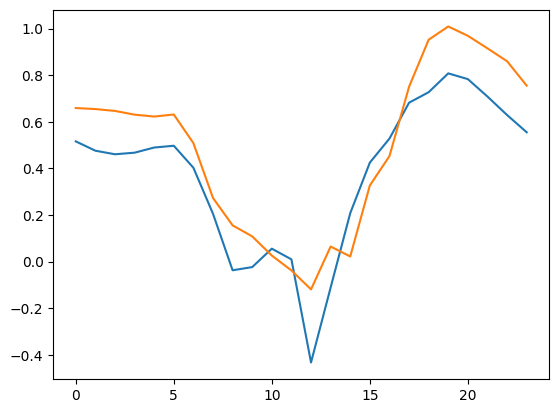

In [ ]:
plt.plot(range(24),y_test)
plt.plot(range(24),y_pred[:,0])

In [ ]:
X_train = training_data.drop(columns = ['time', 'value'])[:int(0.7 * len(training_data))].values
y_train = training_data[:int(0.7 * len(training_data))].value


X_val = training_data.drop(columns = ['time', 'value'])[int(0.7 * len(training_data)):].values
y_val = training_data[int(0.7 * len(training_data)):].value


In [97]:
# predict_from = 1
# predict_until = 24 * 5
# lookback = 10 * 24
# clf = ak.TimeseriesForecaster(
#     lookback=lookback,
#     predict_from=predict_from,
#     predict_until=predict_until,
#     max_trials=100, overwrite=True
# )
# # Train the TimeSeriesForecaster with train data
# clf.fit(x=X_train,
#         y=y_train,x
#         validation_data=(X_val, y_val),)


In [98]:
# # Predict with the best model(includes original training data).
# predictions = clf.predict(data_x_test)
# print(predictions.shape)
# # Evaluate the best model with testing data.
# print(clf.evaluate(data_x_val, data_y_val))